In [2]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import re
from functools import reduce
import glob
from pptx import Presentation
from pptx.util import Inches, Pt
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline   

os.chdir("/Users/aklasnja/2021/")

dslist = ['gov2','robust04','cw09b','cw12b13', 'msmarco']

#bias calc
at_ranklist = [5, 10, 20, 30, 50]

#a reference for model classes
ref_models = pd.read_csv('reference_tables/ref_models.csv')

ref_queries = pd.read_csv('reference_tables/ref_queries.csv')

#liwc variables
sel = ['affect', 'posemo', 'negemo', 'anx', 'anger', 'sad', \
       'social', 'family', 'friend', \
       'cogproc', 'insight', 'cause', 'discrep', 'tentat', 'certain', 'differ', \
       'percept', 'see', 'hear', 'feel', \
       'bio', 'body', 'health', 'sexual', 'ingest', \
       'drives', 'affiliation', 'achieve', 'power', 'reward', 'risk', \
       'focuspast', 'focuspresent', 'focusfuture', \
       'relativ', 'motion', 'space', 'time', \
       'work', 'leisure', 'home', 'money', 'relig', 'death'] 

In [3]:
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV , train_test_split
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,roc_auc_score

In [12]:
r = pd.read_csv('retrievals/ratio_qe.csv')
r = r.drop(columns=["index","qid.1","dataset.1","method.1"]).set_index(["qid","method","dataset"], drop=True)
r = r.join(ref_queries[["qid","method","dataset","gender"]].set_index(["qid","method","dataset"]), how='left').reset_index(drop=False)
r = r.filter(regex=r'^(?!tc|male|female).*$')

ry = r.filter(regex=r'^(tf|bool).*(bias).*(_30)')
ry.columns = ry.columns.str.replace("_30", "")
rx = r.filter(regex=r'^(?!tf|tc|bool|male|female).*(gender|class_1|_30)$')
rx.columns = rx.columns.str.replace("_30", "")

one_hot = pd.get_dummies(rx['gender'])
rx = rx.drop('gender',axis = 1)
rx = rx.join(one_hot)

one_hot = pd.get_dummies(rx['class_1'])
rx = rx.drop('class_1',axis = 1)
rx = rx.join(one_hot)

In [13]:
tuned = {'n_estimators' : stats.randint(500, 1000),
         'learning_rate' : stats.uniform(0.01, 0.5),
         'max_depth' : [3, 4, 5, 6],
         'subsample' : stats.uniform(0.3, 0.6),
         'colsample_bytree' : [0.6, 0.8, 1],
         'min_child_weight': [2, 4, 6, 8],
         'gamma' : [0, 0.5, 1, 1.5, 2]}

grid = RandomizedSearchCV(\
                          XGBRegressor(), \
                          param_distributions=tuned, \
                          n_iter=100, cv=10, random_state=1, \
                          verbose = 3, n_jobs = -1, \
                          return_train_score=True)

#x, x_test, y, y_test = train_test_split(rx, ry, test_size=.20, random_state=1)

In [14]:
response = ['bool_RaB_bias', 'bool_ARaB_bias', 'tf_RaB_bias', 'tf_ARaB_bias'][1]

grid_fit = grid.fit(rx.values, ry[response].values)

print(grid_fit.best_params_)
print(grid_fit.best_score_) #the average of the test cv folds
print(grid_fit.cv_results_['mean_train_score'])

#grid_fit.cv_results_
filename = 'retrievals/ratio_'+response+'_model.sav'
pickle.dump(grid_fit, open(filename, 'wb'))


# final for bool_ARaB_bias:
#Fitting 10 folds for each of 100 candidates, totalling 1000 fits
#{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05917341691652505, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 905, 'subsample': 0.5470727273814318}

# final for tf_ARaB_bias:
#Fitting 10 folds for each of 100 candidates, totalling 1000 fits
#{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05917341691652505, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 905, 'subsample': 0.5470727273814318}

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05917341691652505, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 905, 'subsample': 0.5470727273814318}
0.29563386343269665
[0.08367943 0.98299905 0.07605038 0.0198905  0.25254847 0.02342473
 0.82513699 0.55229955 0.10929565 0.21917876 0.02002768 0.13594138
 0.07707653 0.06324078 0.12322472 0.06232581 0.59063889 0.16776736
 0.02079055 0.08960954 0.70736626 0.16803471 0.99244929 0.03571128
 0.07739546 0.68190104 0.71765997 0.55163484 0.03611772 0.01182869
 0.0444076  0.01870847 0.09009194 0.04414867 0.23943631 0.18880527
 0.01733978 0.85133599 0.56576339 0.01644844 0.13047228 0.03178433
 0.02991886 0.04045863 0.22045417 0.82660924 0.05575725 0.01063515
 0.1795399  0.07686594 0.03864077 0.65068273 0.02376561 0.57499671
 0.06085264 0.02886008 0.99736388 0.06180853 0.08395898 0.11018358
 0.04472443 0.13736299 0.01544294 0.03554253 0.18114136 0.06999573
 0.412073

In [15]:
#grid_fit = pickle.load(open(filename, 'rb'))
model = XGBRegressor(**grid_fit.best_params_)
model_fit = model.fit(rx.values, ry[response].values)

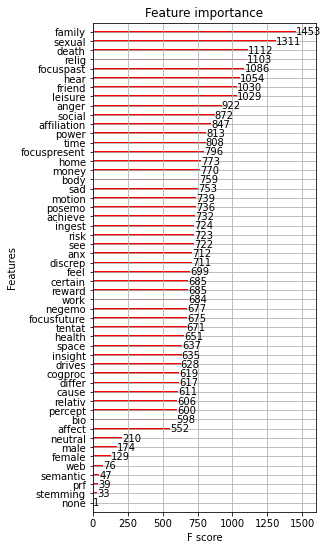

In [16]:
dtrain = xgb.DMatrix(rx, label=ry[response])
dtrain.feature_names
#- ”weight” is the number of times a feature appears in a tree
#- ”gain” is the average information gain averaged over all trees
model.get_booster().get_score(importance_type='gain')
mapper = {'f{0}'.format(i): v for i, v in enumerate(dtrain.feature_names)}
mapped = {mapper[k]: v for k, v in model.get_booster().get_score(importance_type='weight').items()}

filename = 'retrievals/png/ratio_'+response+'_plot_importance.png'
xgb.plot_importance(mapped, color='red')
figure = plt.gcf() # get current figure
figure.set_size_inches(4, 9)
plt.savefig(filename, dpi=100, bbox_inches='tight')

In [17]:
#https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Force%20Plot%20Colors.html
import shap
shap.initjs()

explainer = shap.TreeExplainer(model_fit)
shap_values = explainer.shap_values(rx)

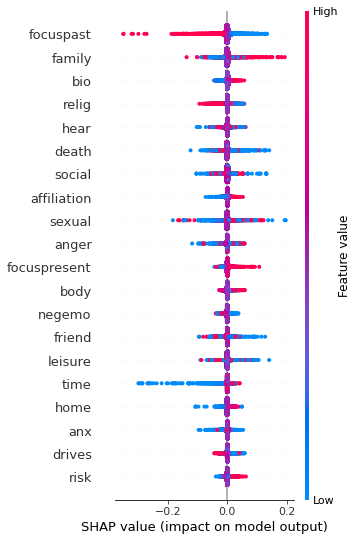

In [18]:
filename = 'retrievals/png/ratio_'+response+'_shap_summary.png'
shap.summary_plot(shap_values, rx, show=False)
figure = plt.gcf() # get current figure
figure.set_size_inches(4, 9)
plt.savefig(filename, dpi=100, bbox_inches='tight')

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


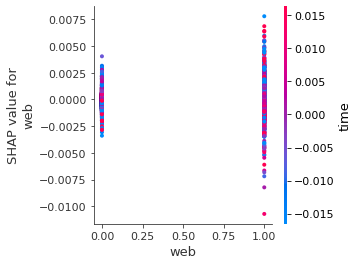

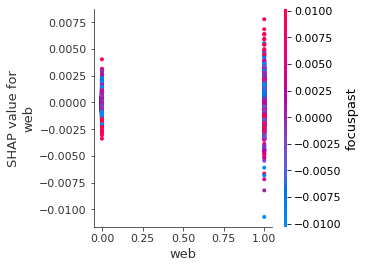

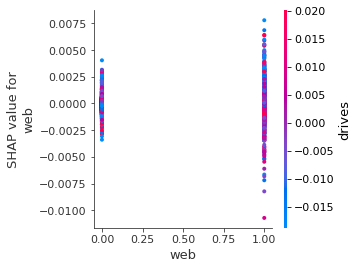

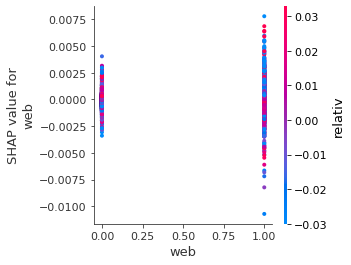

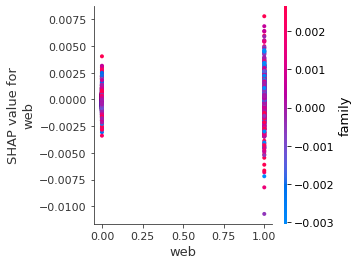

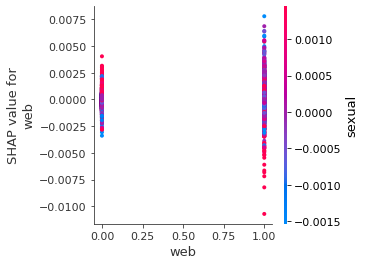

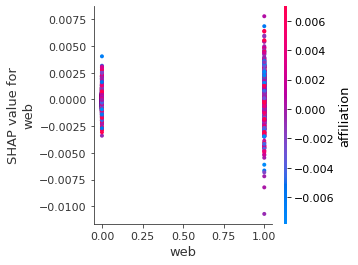

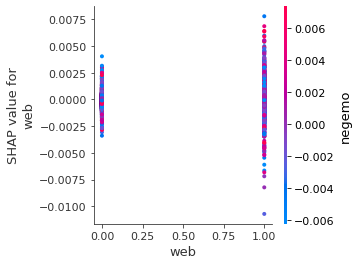

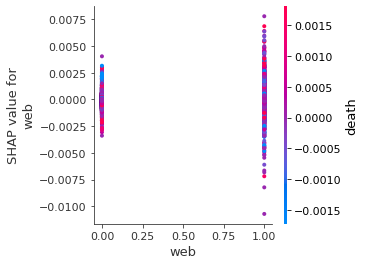

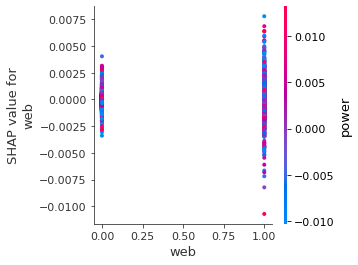

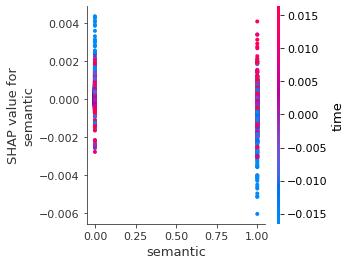

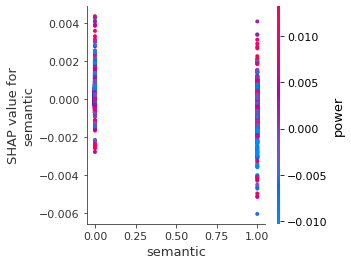

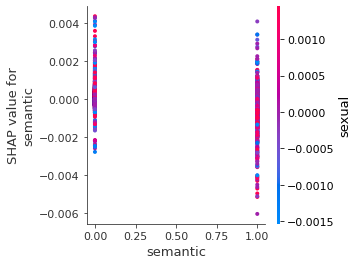

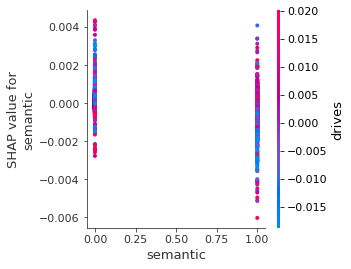

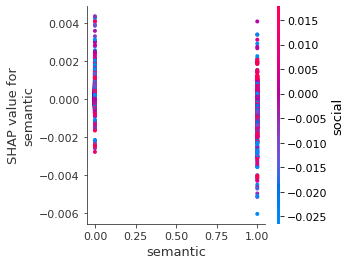

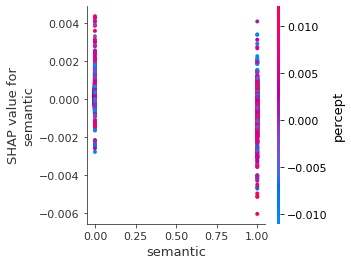

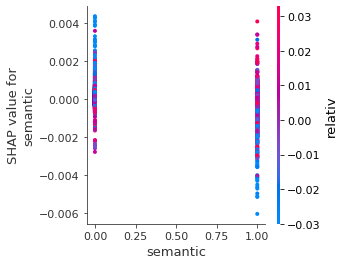

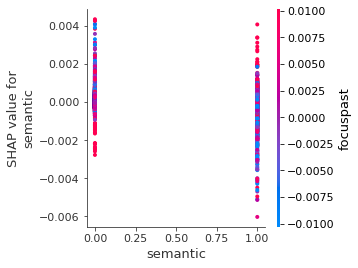

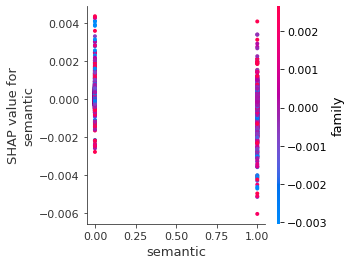

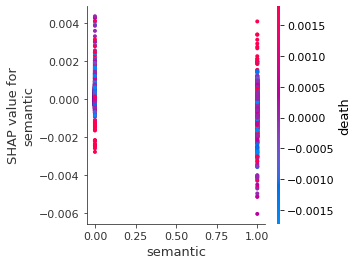

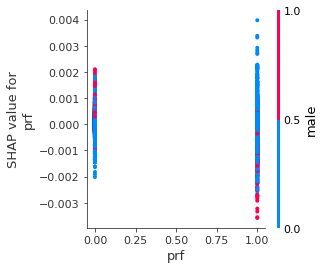

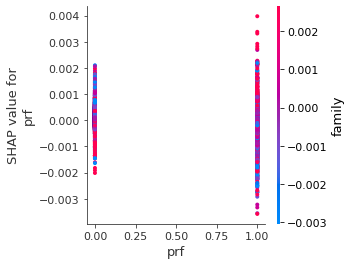

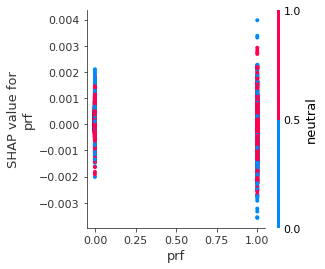

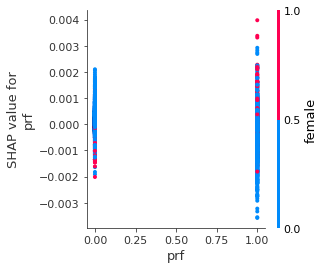

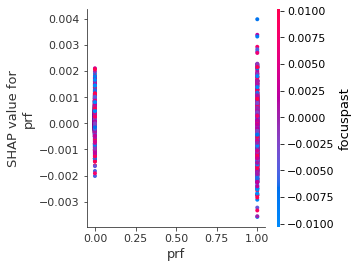

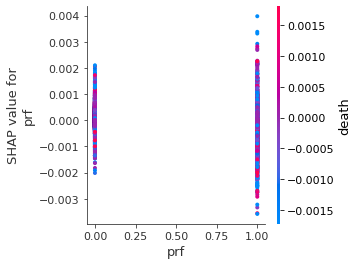

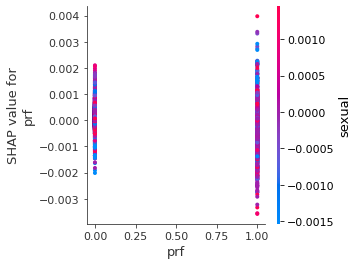

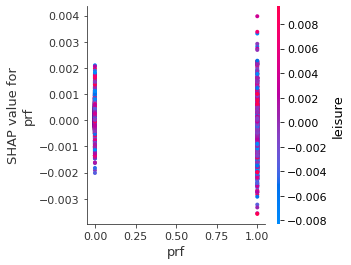

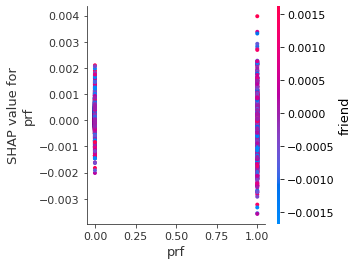

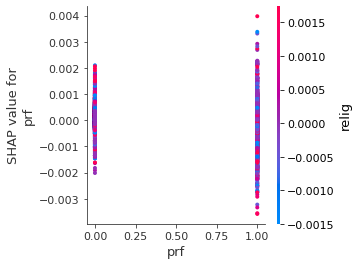

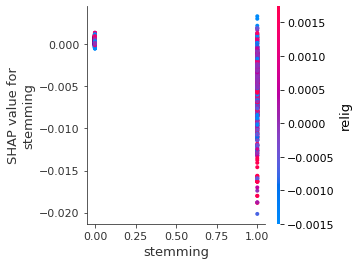

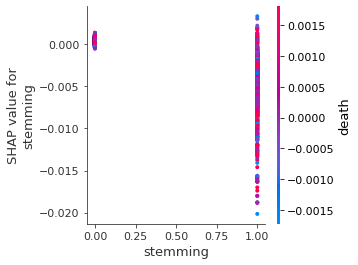

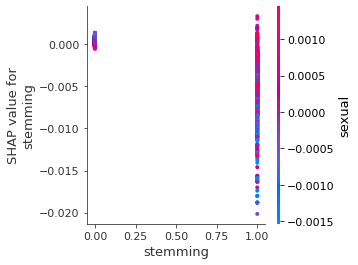

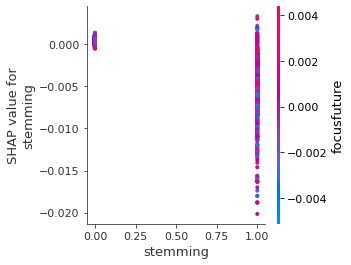

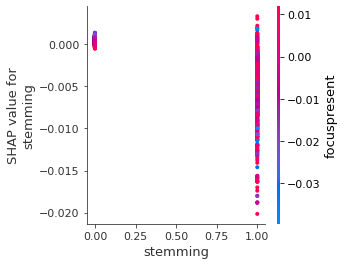

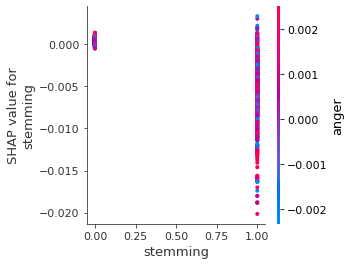

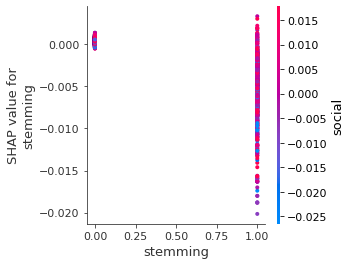

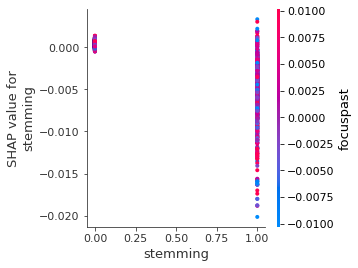

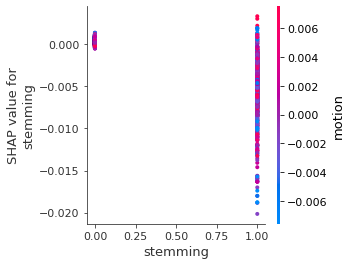

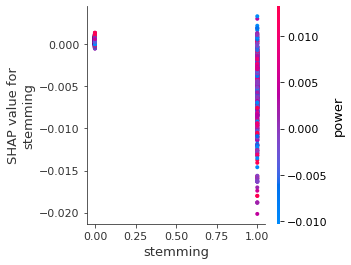

In [19]:
for name in ['web','semantic','prf','stemming']:
    inds = shap.approximate_interactions(name, shap_values, rx)
    for i in range(10):
        shap.dependence_plot(name, shap_values, rx, interaction_index=inds[i], show=False)
        filename = 'retrievals/png/ratio_'+response+'_dep_'+name+'_'+str(i)+'.png'
        figure = plt.gcf() # get current figure
        figure.set_size_inches(4, 4)
        plt.savefig(filename, dpi=100, bbox_inches='tight')